In [3]:
!curl -o notMNIST_small.tar.gz http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz
!curl -o notMNIST_large.tar.gz http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
!tar xzf notMNIST_small.tar.gz
!tar xzf notMNIST_large.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8259k  100 8259k    0     0  1749k      0  0:00:04  0:00:04 --:--:-- 1801k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  235M  100  235M    0     0  1156k      0  0:03:28  0:03:28 --:--:-- 1509k    0     0  1180k      0  0:03:24  0:02:19  0:01:05  940k


In [7]:
from utils import *
nmnist = read_mnist('data/')

In [8]:
train_images, train_labels, test_images, test_labels = nmnist[0][0], nmnist[0][1], nmnist[1][0], nmnist[1][1]
print("X_train:{}, Y_train:{}, X_test: {}, Y_test: {}".format(train_images.shape,train_labels.shape,test_images.shape,\
                                                              test_labels.shape))


X_train:(55000, 784), Y_train:(55000, 10), X_test: (5000, 784), Y_test: (5000, 10)


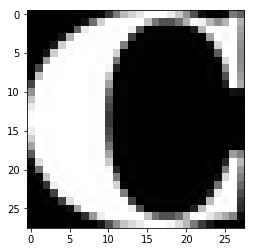

In [9]:
show(train_images[5].reshape([28,28]))

In [10]:
X = tf.placeholder(tf.float32,[None,784])
Y= tf.placeholder(tf.float32,[None,10])
sess = tf.InteractiveSession()

In [11]:
def get_weights(shape):
    weight = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(weight)

def get_bias(shape):
    bias = tf.constant(0.1,shape=shape)
    return tf.Variable(bias)

def conv2X2(x,w):
    return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding="SAME")

def max2X2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")

In [12]:
n_samples = train_images.shape[0]
batch_size = 100
n_batches = int(n_samples/batch_size)

W_conv1 = get_weights([5,5,1,32])
b_conv1 = get_bias([32])
h_conv1 = tf.nn.relu(conv2X2(tf.reshape(X,[-1,28,28,1]),W_conv1) + b_conv1)
h_pool1 = max2X2(h_conv1)

W_conv2 = get_weights([5,5,32,64])
b_conv2 = get_bias([64])
h_conv2 = tf.nn.relu(conv2X2(h_pool1,W_conv2) + b_conv2)
h_pool2 = max2X2(h_conv2)

W_dense1 = get_weights([7*7*64,1024])
b_dense1 = get_bias([1024])
h_pool2_flat = tf.reshape(h_pool2,[-1,7*7*64])
h_dense1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_dense1) + b_dense1)

keep_prob = tf.placeholder(tf.float32)
h_drop = tf.nn.dropout(h_dense1,keep_prob)

W_soft1 = get_weights([1024,10])
b_soft1 = get_bias([10])
y_pred = tf.matmul(h_dense1,W_soft1) + b_soft1

entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred,labels=Y)
train_step = tf.train.AdamOptimizer(1e-4).minimize(entropy)
correct_pred = tf.equal(tf.arg_max(y_pred,1), tf.arg_max(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))
sess.run(tf.global_variables_initializer())

In [13]:
index_in_epoch = 0
epochs_completed = 0
def get_next_batch(batch_size):
    
    global index_in_epoch
    global epochs_completed
    global train_images
    global train_labels
    
    start = index_in_epoch
    index_in_epoch += batch_size

    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > n_samples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(n_samples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= n_samples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]


In [18]:
begin,end=0,0
for i in range(20000):
    batch = get_next_batch(batch_size)
    if i%100 ==0:
        print("step:{},accuracy:{}".format(i,accuracy.eval(feed_dict={X:batch[0],Y:batch[1],keep_prob:1.0})))
    train_step.run(feed_dict={X:batch[0],Y:batch[1],keep_prob:0.5}) 
test_accuracy = accuracy.eval(feed_dict={X:test_images,Y:test_labels,keep_prob:1.0})    

step:0,accuracy:0.8899999856948853
step:100,accuracy:0.8500000238418579
step:200,accuracy:0.8999999761581421
step:300,accuracy:0.9200000166893005
step:400,accuracy:0.9300000071525574
step:500,accuracy:0.9200000166893005
step:600,accuracy:0.9700000286102295
step:700,accuracy:0.9300000071525574
step:800,accuracy:0.8999999761581421
step:900,accuracy:0.8899999856948853
step:1000,accuracy:0.8600000143051147
step:1100,accuracy:0.949999988079071
step:1200,accuracy:0.9300000071525574
step:1300,accuracy:0.9700000286102295
step:1400,accuracy:0.8999999761581421
step:1500,accuracy:0.949999988079071
step:1600,accuracy:0.9200000166893005
step:1700,accuracy:0.9200000166893005
step:1800,accuracy:0.949999988079071
step:1900,accuracy:0.8999999761581421
step:2000,accuracy:0.9399999976158142
step:2100,accuracy:0.8899999856948853
step:2200,accuracy:0.9599999785423279
step:2300,accuracy:0.9200000166893005
step:2400,accuracy:0.9399999976158142
step:2500,accuracy:0.9200000166893005
step:2600,accuracy:0.930000

In [19]:
print("test accuracy: {}".format(test_accuracy))

test accuracy: 0.906000018119812


In [20]:
predictions = y_pred.eval(feed_dict={X:test_images,Y:test_labels,keep_prob:1.0})
predicted_label = []
for pe in predictions:
    predicted_label.append(np.argmax(pe))
actual_label = []
for a in test_labels:
    actual_label.append(np.argmax(a))

In [21]:
from sklearn.metrics import classification_report
print(classification_report(actual_label,predicted_label))

             precision    recall  f1-score   support

          0       0.90      0.91      0.91       507
          1       0.85      0.94      0.89       515
          2       0.95      0.90      0.92       499
          3       0.91      0.90      0.90       518
          4       0.93      0.89      0.91       509
          5       0.94      0.91      0.92       507
          6       0.92      0.93      0.92       466
          7       0.90      0.92      0.91       492
          8       0.86      0.87      0.87       507
          9       0.92      0.89      0.91       480

avg / total       0.91      0.91      0.91      5000

